- foi definido no colab anterior os 2 melhores modelos
  - RF: RFE (Top 5)	Random Forest	0.895455	0.895544	RFE (5)
  - MLP: Mutual Info (Top 10) MLP 0.909091  0.909091  MI (10)

- explicabilidade global: SHAP
  - rapidamente entender feature importances

- explicabilidade local: SHAP (RF) e LIME (MLP)
  - examinar casos individuais e comparar MLP vs RF

- metodos complementares (LIME e Permutation) para validar consistencia das explicações



In [ ]:
!pip install shap lime scikit-posthocs --quiet

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import shap
from lime import lime_tabular

DRIVE_PATH = '/content/drive/MyDrive/MATERIAS/INF493_CD/TRAB_FINAL/dataset/Student_Stress_Monitoring_Datasets/'
os.makedirs(DRIVE_PATH, exist_ok=True)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 18.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## carregamento dos dados

In [ ]:
BASE_URL = "https://raw.githubusercontent.com/AnaClaraGuerra22/INF-493-CD/4fc21c3e54b3aaddcd4f584e0460e097f4999fa9/TRAB%20FINAL/DATASET/DATASET%20MODELOS"

df_resultados = pd.read_csv(f"{BASE_URL}/df_resultados.csv")

df_resultados.head(10)


,Subconjunto,Modelo,Acurácia,F1 Score (macro),Subconjunto_Abreviado
0,Mutual Info (Top 10),MLP,0.909091,0.909137,MI (10)
1,Mutual Info (Top 5),Regressão Logística,0.904545,0.905831,MI (5)
2,RFE (Top 5),Regressão Logística,0.904545,0.904857,RFE (5)
3,RFE (Top 10),Regressão Logística,0.904545,0.904857,RFE (10)
4,Mutual Info (Top 10),Regressão Logística,0.900000,0.901390,MI (10)
5,RFE (Top 5),Random Forest,0.895455,0.895544,RFE (5)
6,RFE (Top 10),Random Forest,0.895455,0.895544,RFE (10)
7,Mutual Info (Top 10),SVM,0.890909,0.892004,MI (10)
8,Mutual Info (Top 10),KNN,0.890909,0.890668,MI (10)
9,Mutual Info (Top 10),Gradient Boosting,0.890909,0.890877,MI (10)


In [ ]:
best_mlp = df_resultados[df_resultados["Modelo"] == "MLP"].sort_values(
    by=["Acurácia", "F1 Score (macro)"], ascending=False).iloc[0]

best_rf = df_resultados[df_resultados["Modelo"] == "Random Forest"].sort_values(
    by=["Acurácia", "F1 Score (macro)"], ascending=False).iloc[0]

print("Melhor MLP:")
display(best_mlp)

print("\n\nMelhor Random Forest:")
display(best_rf)


Melhor MLP:


,0
Subconjunto,Mutual Info (Top 10)
Modelo,MLP
Acurácia,0.909091
F1 Score (macro),0.909137
Subconjunto_Abreviado,MI (10)




Melhor Random Forest:


,5
Subconjunto,RFE (Top 5)
Modelo,Random Forest
Acurácia,0.895455
F1 Score (macro),0.895544
Subconjunto_Abreviado,RFE (5)


In [ ]:
BASE_URL = "https://raw.githubusercontent.com/AnaClaraGuerra22/INF-493-CD/4fc21c3e54b3aaddcd4f584e0460e097f4999fa9/TRAB%20FINAL/DATASET"


df_scaled = pd.read_csv(f"{BASE_URL}/DATASET_PREPROCESSADOS/StressLevelDataset_Scaled.csv")
print("Dataset carregado com sucesso!")
print(df_scaled.head(), "\n")

y = df_scaled["stress_level"]
X_all = df_scaled.drop(columns=["stress_level"])



paths = {
    "MI (10)": f"{BASE_URL}/SELECAO_FEATURES/X_mi_top10.csv",
    "MI (5)": f"{BASE_URL}/SELECAO_FEATURES/X_mi_top5.csv",
    "RFE (10)": f"{BASE_URL}/SELECAO_FEATURES/X_rfe_top10.csv",
    "RFE (5)": f"{BASE_URL}/SELECAO_FEATURES/X_rfe_top5.csv",
    "RF (10)": f"{BASE_URL}/SELECAO_FEATURES/X_rf_top10.csv",
    "RF (5)": f"{BASE_URL}/SELECAO_FEATURES/X_rf_top5.csv"
}



best_mlp_subset = "MI (10)"
best_rf_subset = "RFE (5)"

X_mlp = pd.read_csv(paths[best_mlp_subset])
X_rf = pd.read_csv(paths[best_rf_subset])

print("\nShapes carregados:")
print(f"MLP ({best_mlp_subset}):", X_mlp.shape)
print(f"RF  ({best_rf_subset}):", X_rf.shape)


Dataset carregado com sucesso!
   id_pessoa  anxiety_level  self_esteem  mental_health_history  depression  \
0          1       0.666667     0.666667                    0.0    0.407407   
1          2       0.714286     0.266667                    1.0    0.555556   
2          3       0.571429     0.600000                    1.0    0.518519   
3          4       0.761905     0.400000                    1.0    0.555556   
4          5       0.761905     0.933333                    0.0    0.259259   

   headache  blood_pressure  sleep_quality  breathing_problem  noise_level  \
0       0.4             0.0            0.4                0.8          0.4   
1       1.0             1.0            0.2                0.8          0.6   
2       0.4             0.0            0.4                0.4          0.4   
3       0.8             1.0            0.2                0.6          0.8   
4       0.4             1.0            1.0                0.2          0.6   

   ...  basic_needs  acad

## Treinar de novo os modelos


mlp = MLPClassifier(
    hidden_layer_sizes=(50,),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    random_state=42
)


### Divisão treino/teste
- usar mesma seed/estratificação
- mesmos splits reprodutiveis

In [ ]:
X_mlp_train, X_mlp_test, y_train, y_test = train_test_split(
    X_mlp, y, test_size=0.2, random_state=42, stratify=y)

X_rf_train, X_rf_test, _, _ = train_test_split(
    X_rf, y, test_size=0.2, random_state=42, stratify=y)

mlp = MLPClassifier(
    hidden_layer_sizes=(50,),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    random_state=42
)

mlp.fit(X_mlp_train, y_train)
rf.fit(X_rf_train, y_train)

print("Modelos treinados novamente")


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Modelos treinados novamente


## mapear as categorias psicológicas, fisiológicas, sociais, ambientais e acadêmicas das variaveis



In [ ]:
category_mapping = {
    # Psicologicos
    'anxiety_level': 'Psicológicos', 'self_esteem': 'Psicológicos',
    'mental_health_history': 'Psicológicos', 'depression': 'Psicológicos',

    # Fisiologicos
    'headache': 'Fisiológicos', 'blood_pressure': 'Fisiológicos',
    'sleep_quality': 'Fisiológicos', 'breathing_problem': 'Fisiológicos',

    # Ambientais
    'noise_level': 'Ambientais', 'living_conditions': 'Ambientais',
    'safety': 'Ambientais', 'basic_needs': 'Ambientais',

    # Academicos
    'academic_performance': 'Acadêmicos', 'study_load': 'Acadêmicos',
    'teacher_student_relationship': 'Acadêmicos', 'future_career_concerns': 'Acadêmicos',

    # Sociais
    'social_support': 'Sociais', 'peer_pressure': 'Sociais',
    'extracurricular_activities': 'Sociais', 'bullying': 'Sociais'
}

## Explicabilidade Global (SHAP)

### para Random Forest

<Figure size 1000x600 with 0 Axes>

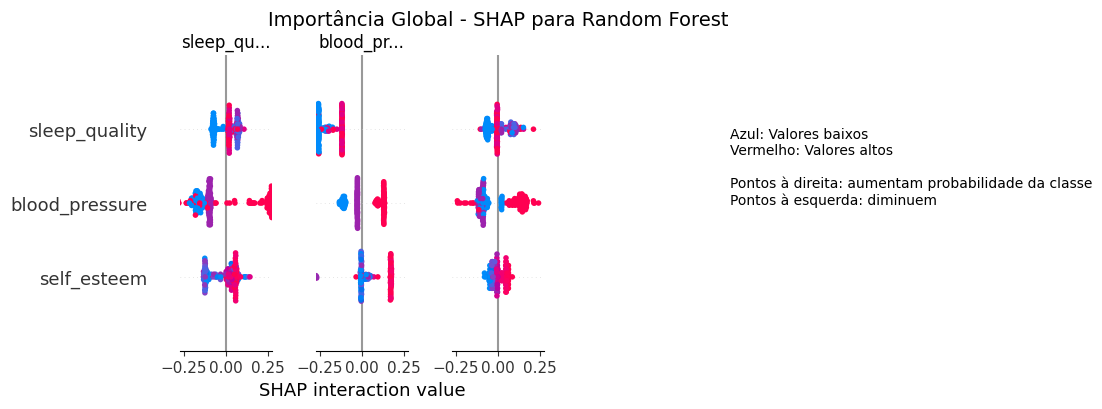

In [ ]:
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_rf_test)


plt.figure(figsize=(10, 6))

shap.summary_plot(
    shap_values_rf,
    X_rf_test,
    feature_names=X_rf_test.columns,
    max_display=4,
    plot_size=(10, 6),
    show=False
)

plt.title("Importância Global - SHAP para Random Forest\n", fontsize=14)
#plt.xlabel("Valor SHAP (impacto na previsão)", fontsize=12)
#lt.ylabel("Variáveis", fontsize=12)


plt.figtext(
    1.05, 0.5,
    "Azul: Valores baixos\nVermelho: Valores altos\n\nPontos à direita: aumentam probabilidade da classe\nPontos à esquerda: diminuem",
    fontsize=10, ha="left"
)


plt.tight_layout()
plt.show()


Formato original do SHAP: (220, 10, 3)


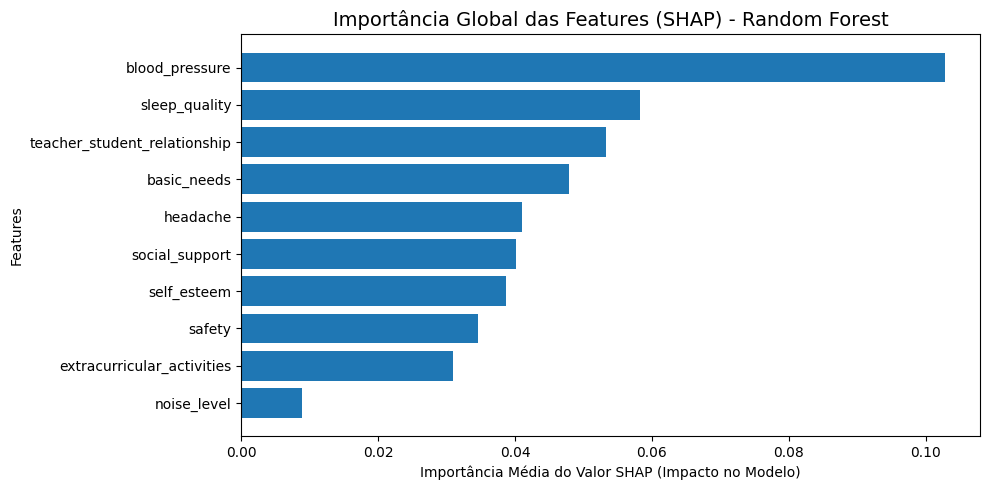

,Feature,SHAP Importance,SHAP Percentage
0,blood_pressure,0.102802,22.52%
1,sleep_quality,0.058202,12.75%
2,teacher_student_relationship,0.053351,11.69%
3,basic_needs,0.047824,10.48%
4,headache,0.041081,9.00%
5,social_support,0.040158,8.80%
6,self_esteem,0.038658,8.47%
7,safety,0.034657,7.59%
8,extracurricular_activities,0.030871,6.76%
9,noise_level,0.008929,1.96%


In [ ]:
print("Formato original do SHAP:", np.array(shap_values_rf).shape)

shap_arr = np.array(shap_values_rf)

# media absoluta por amostra (eixo 0)
shap_abs_mean_by_sample = np.mean(np.abs(shap_arr), axis=0)

mean_shap = np.mean(shap_abs_mean_by_sample, axis=1)

feature_importance = pd.DataFrame({
    "Feature": X_rf_test.columns,
    "SHAP Importance": mean_shap
}).sort_values(by="SHAP Importance", ascending=False).reset_index(drop=True)

total_shap_importance = feature_importance["SHAP Importance"].sum()
feature_importance["SHAP Percentage"] = (
    feature_importance["SHAP Importance"] / total_shap_importance * 100
).map('{:.2f}%'.format)

plt.figure(figsize=(10, 5))
plt.barh(feature_importance["Feature"], feature_importance["SHAP Importance"])
plt.gca().invert_yaxis()
plt.title("Importância Global das Features (SHAP) - Random Forest", fontsize=14)
plt.xlabel("Importância Média do Valor SHAP (Impacto no Modelo)")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

display(feature_importance)

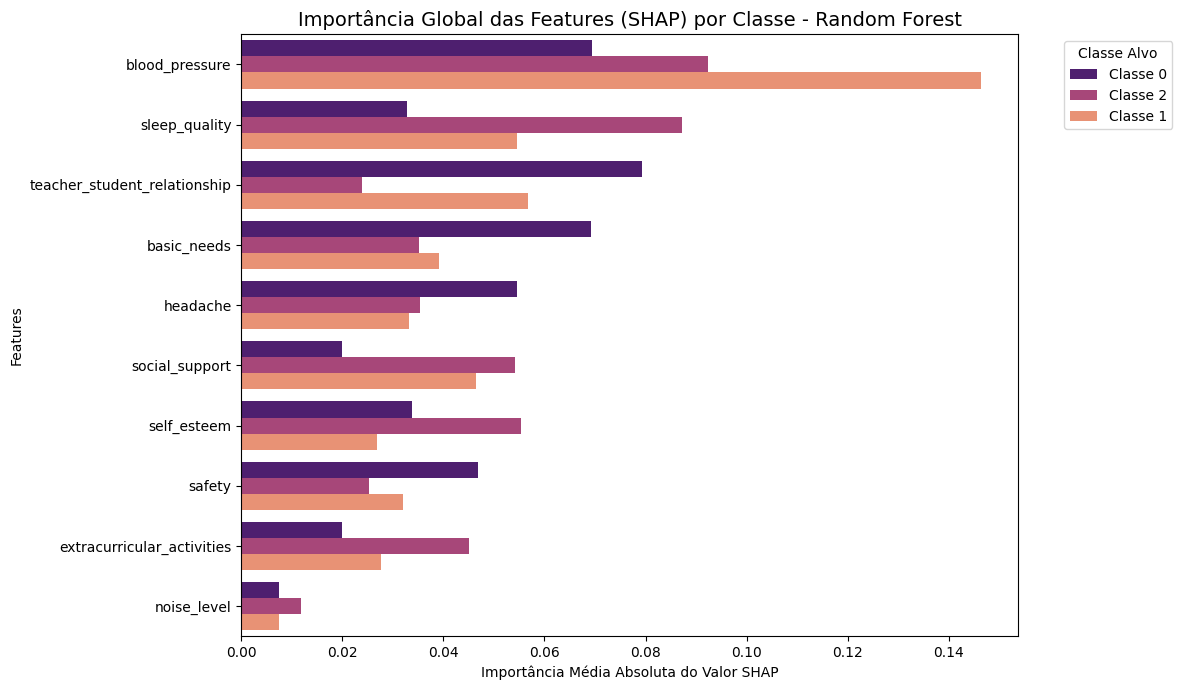

,Feature,Classe,Importância SHAP Média
2,blood_pressure,Classe 0,0.069505
22,blood_pressure,Classe 2,0.092452
12,blood_pressure,Classe 1,0.146449
1,sleep_quality,Classe 0,0.032850
21,sleep_quality,Classe 2,0.087121
11,sleep_quality,Classe 1,0.054635
14,teacher_student_relationship,Classe 1,0.056809
4,teacher_student_relationship,Classe 0,0.079302
24,teacher_student_relationship,Classe 2,0.023942
5,basic_needs,Classe 0,0.069240


In [ ]:
shap_abs_mean_by_sample = np.mean(np.abs(shap_arr), axis=0)


df_shap_class = pd.DataFrame(
    shap_abs_mean_by_sample,
    index=X_rf_test.columns,
    columns=[f"Classe {c}" for c in range(shap_abs_mean_by_sample.shape[1])]
)

df_shap_long = df_shap_class.reset_index().rename(columns={'index': 'Feature'})
df_shap_long = df_shap_long.melt(
    id_vars='Feature',
    var_name='Classe',
    value_name='Importância SHAP Média'
)

feature_order = df_shap_long.groupby('Feature')['Importância SHAP Média'].sum().sort_values(ascending=False).index
df_shap_long['Feature'] = pd.Categorical(df_shap_long['Feature'], categories=feature_order, ordered=True)
df_shap_long = df_shap_long.sort_values(by='Feature')



plt.figure(figsize=(12, 7))
sns.barplot(
    data=df_shap_long,
    x='Importância SHAP Média',
    y='Feature',
    hue='Classe',
    palette='magma'
)
plt.title("Importância Global das Features (SHAP) por Classe - Random Forest", fontsize=14)
plt.xlabel("Importância Média Absoluta do Valor SHAP")
plt.ylabel("Features")
plt.legend(title='Classe Alvo', bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()

display(df_shap_long.head(15))

/tmp/ipython-input-98109971.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


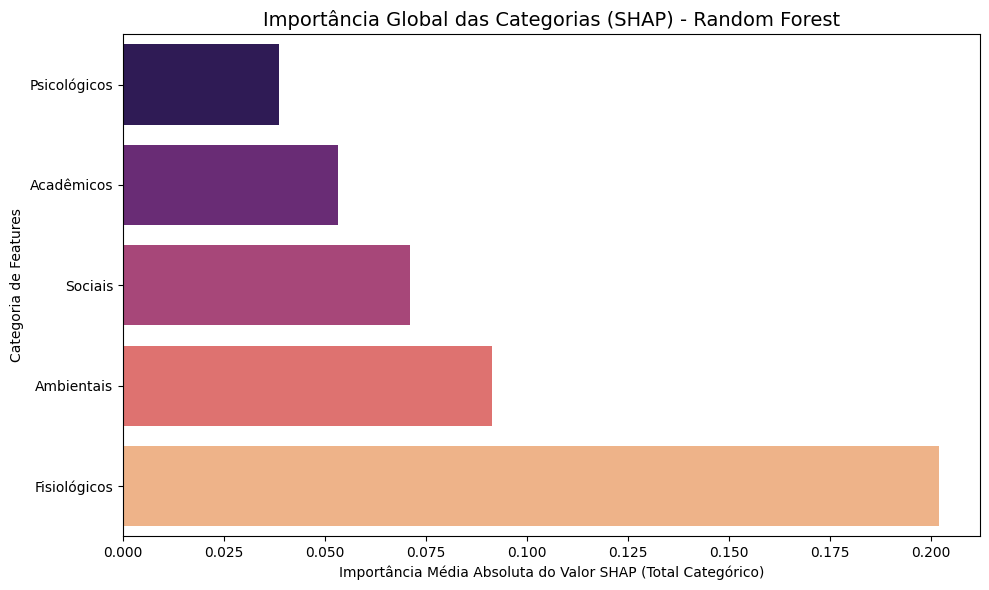

,Category,SHAP Importance,SHAP Percentage
3,Psicológicos,0.038658,8.47%
0,Acadêmicos,0.053351,11.69%
4,Sociais,0.071029,15.56%
1,Ambientais,0.091410,20.02%
2,Fisiológicos,0.202085,44.27%


In [ ]:
feature_importance['Category'] = feature_importance['Feature'].map(category_mapping)

category_importance = feature_importance.groupby('Category')['SHAP Importance'].sum().reset_index()

total_category_importance = category_importance['SHAP Importance'].sum()
category_importance['SHAP Percentage'] = (
    category_importance['SHAP Importance'] / total_category_importance * 100
).map('{:.2f}%'.format)


category_importance = category_importance.sort_values(
    by='SHAP Importance', ascending=True)


plt.figure(figsize=(10, 6))
sns.barplot(
    data=category_importance,
    x='SHAP Importance',
    y='Category',
    palette='magma'
)
plt.title("Importância Global das Categorias (SHAP) - Random Forest", fontsize=14)
plt.xlabel("Importância Média Absoluta do Valor SHAP (Total Categórico)")
plt.ylabel("Categoria de Features")
plt.tight_layout()
plt.show()

display(category_importance)

### para MLP (Rede Neural — Caixa-preta)

Usar KernelExplainer, o MLP não é interpretavel diretamente

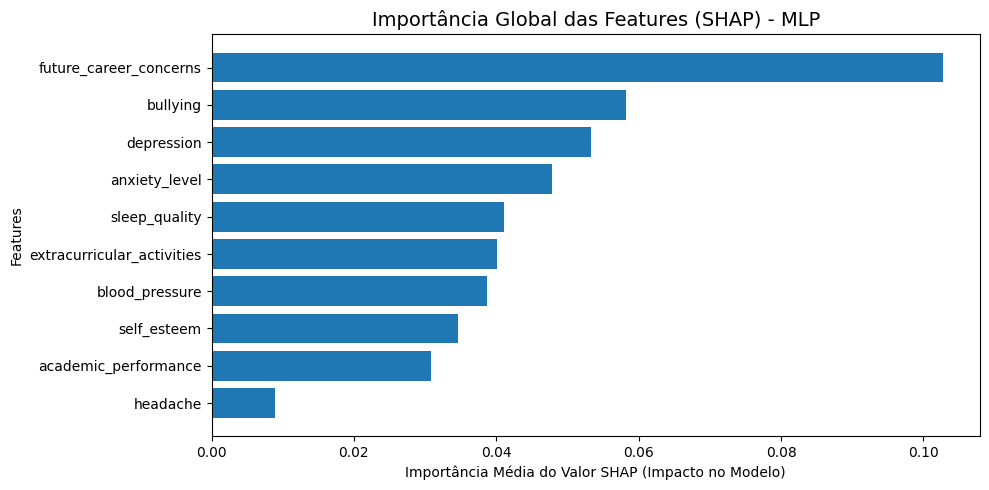

,Feature,SHAP Importance,SHAP Percentage
0,future_career_concerns,0.102802,22.52%
1,bullying,0.058202,12.75%
2,depression,0.053351,11.69%
3,anxiety_level,0.047824,10.48%
4,sleep_quality,0.041081,9.00%
5,extracurricular_activities,0.040158,8.80%
6,blood_pressure,0.038658,8.47%
7,self_esteem,0.034657,7.59%
8,academic_performance,0.030871,6.76%
9,headache,0.008929,1.96%


In [ ]:
shap_abs_mean_by_sample = np.mean(np.abs(shap_arr), axis=0)

mean_shap = np.mean(shap_abs_mean_by_sample, axis=1)

feature_importance = pd.DataFrame({
    "Feature": X_mlp_test.columns,
    "SHAP Importance": mean_shap
}).sort_values(by="SHAP Importance", ascending=False).reset_index(drop=True)

total_shap_importance = feature_importance["SHAP Importance"].sum()
feature_importance["SHAP Percentage"] = (
    feature_importance["SHAP Importance"] / total_shap_importance * 100
).map('{:.2f}%'.format)

plt.figure(figsize=(10, 5))
plt.barh(feature_importance["Feature"], feature_importance["SHAP Importance"])
plt.gca().invert_yaxis()
plt.title("Importância Global das Features (SHAP) - MLP", fontsize=14)
plt.xlabel("Importância Média do Valor SHAP (Impacto no Modelo)")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

display(feature_importance)

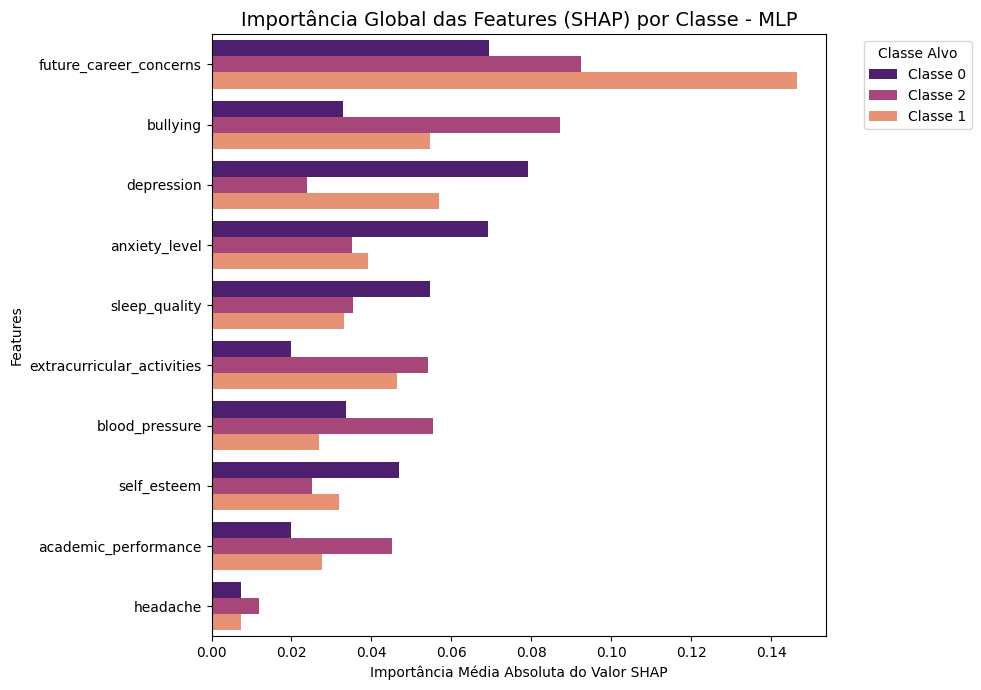

,Feature,Classe,Importância SHAP Média
2,future_career_concerns,Classe 0,0.069505
22,future_career_concerns,Classe 2,0.092452
12,future_career_concerns,Classe 1,0.146449
1,bullying,Classe 0,0.032850
21,bullying,Classe 2,0.087121
11,bullying,Classe 1,0.054635
14,depression,Classe 1,0.056809
4,depression,Classe 0,0.079302
24,depression,Classe 2,0.023942
5,anxiety_level,Classe 0,0.069240


In [ ]:
shap_abs_mean_by_sample = np.mean(np.abs(shap_arr), axis=0)

df_shap_class = pd.DataFrame(
    shap_abs_mean_by_sample,
    index=X_mlp_test.columns,
    columns=[f"Classe {c}" for c in range(shap_abs_mean_by_sample.shape[1])]
)

df_shap_long = df_shap_class.reset_index().rename(columns={'index': 'Feature'})
df_shap_long = df_shap_long.melt(
    id_vars='Feature',
    var_name='Classe',
    value_name='Importância SHAP Média'
)

feature_order = df_shap_long.groupby('Feature')['Importância SHAP Média'].sum().sort_values(ascending=False).index
df_shap_long['Feature'] = pd.Categorical(df_shap_long['Feature'], categories=feature_order, ordered=True)
df_shap_long = df_shap_long.sort_values(by='Feature')


plt.figure(figsize=(10, 7))
sns.barplot(
    data=df_shap_long,
    x='Importância SHAP Média',
    y='Feature',
    hue='Classe',
    palette='magma'
)
plt.title("Importância Global das Features (SHAP) por Classe - MLP", fontsize=14)
plt.xlabel("Importância Média Absoluta do Valor SHAP")
plt.ylabel("Features")
plt.legend(title='Classe Alvo', bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()

display(df_shap_long.head(15))

/tmp/ipython-input-99297750.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


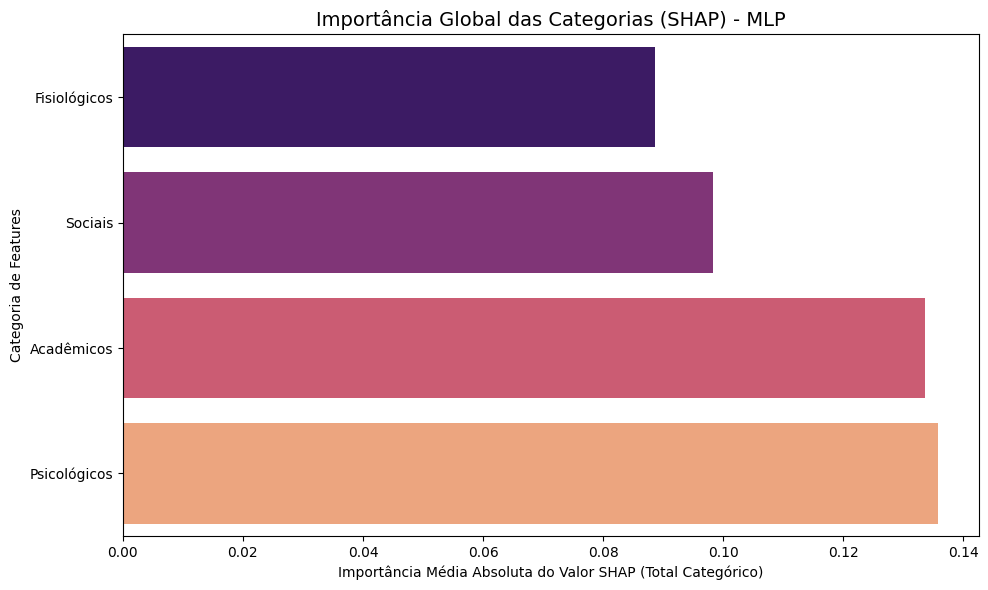

,Category,SHAP Importance,SHAP Percentage
1,Fisiológicos,0.088667,19.42%
3,Sociais,0.098360,21.55%
0,Acadêmicos,0.133673,29.28%
2,Psicológicos,0.135832,29.75%


In [ ]:
feature_importance['Category'] = feature_importance['Feature'].map(category_mapping)
category_importance = feature_importance.groupby('Category')['SHAP Importance'].sum().reset_index()


total_category_importance = category_importance['SHAP Importance'].sum()
category_importance['SHAP Percentage'] = (
    category_importance['SHAP Importance'] / total_category_importance * 100
).map('{:.2f}%'.format)


category_importance = category_importance.sort_values(
    by='SHAP Importance', ascending=True)


plt.figure(figsize=(10, 6))
sns.barplot(
    data=category_importance,
    x='SHAP Importance',
    y='Category',
    palette='magma'
)
plt.title("Importância Global das Categorias (SHAP) - MLP", fontsize=14)
plt.xlabel("Importância Média Absoluta do Valor SHAP (Total Categórico)")
plt.ylabel("Categoria de Features")
plt.tight_layout()
plt.show()

display(category_importance)

## EXPLICABILIDADE LOCAL

- SHAP (TreeExplainer): Random Forest
- LIME (modelo agnóstico): MLP

- permite entender por que uma instância específica (um aluno) recebeu uma determinada previsão de estresse

### SHAP - RF


- 3 cenarios no conjunto de teste (X_rf_test)
  - instancia 1 (Acerto): Um aluno onde o modelo acertou a previsão
  - instancia 2 (Erro): Um aluno onde o modelo errou a previsão
  - instancia 3 (Borda): Um aluno onde a previsão está muito próxima do valor base (base value)


In [ ]:

explainer = shap.TreeExplainer(rf)
#shap_values = explainer.shap_values(X_rf_test)
shap_values = explainer.shap_values(X_rf_test, check_additivity=False)

print("Novo formato SHAP:", np.array(shap_values).shape)


Novo formato SHAP: (220, 10, 3)


In [ ]:
rf_pred = rf.predict(X_rf_test)
rf_proba = rf.predict_proba(X_rf_test)

idx_acerto = np.where(rf_pred == y_test)[0][0]
idx_erro = np.where(rf_pred != y_test)[0][0]

sorted_probs = np.sort(rf_proba, axis=1)
uncertainty_scores = np.abs(sorted_probs[:, -1] - sorted_probs[:, -2])

idx_borda = np.argmin(uncertainty_scores)

print(idx_acerto, idx_erro, idx_borda)


0 4 26


In [ ]:
def explicar_instancia(idx, nome):
    instance = X_rf_test.iloc[idx]
    instance_df = instance.to_frame().T

    pred = rf.predict(instance_df)[0]
    proba = rf.predict_proba(instance_df)[0].max()

    print(f"\nExplicação Local — {nome} (Índice Original {idx})")
    print(f"Verdadeiro: {y_test.iloc[idx]}")
    print(f"Predito: {pred}")
    print(f"Confiança: {proba:.2f}")

    # garante indice
    idx_safe = idx if idx < shap_values[pred].shape[0] else idx % shap_values[pred].shape[0]

    shap_vector = shap_values[pred][idx_safe]
    shap_vector = np.array(shap_vector).flatten()

    shap.waterfall_plot(
        shap.Explanation(
            values=shap_vector,
            base_values=explainer.expected_value[pred],
            data=instance.values,
            feature_names=X_rf_test.columns.tolist()
        )
    )



Explicação Local — ACERTO (Índice Original 0)
Verdadeiro: 0
Predito: 0
Confiança: 1.00


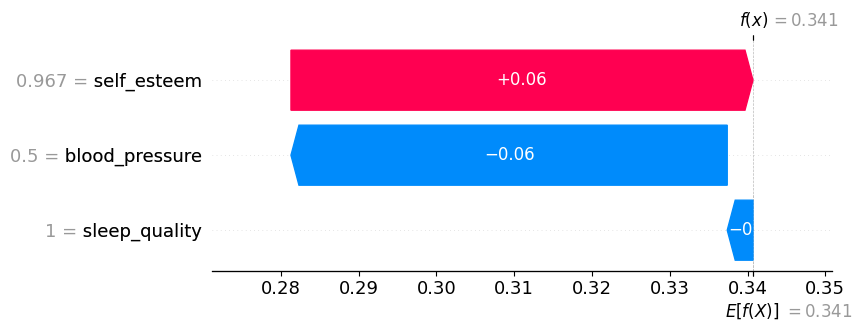


Explicação Local — ERRO (Índice Original 4)
Verdadeiro: 0
Predito: 2
Confiança: 0.41


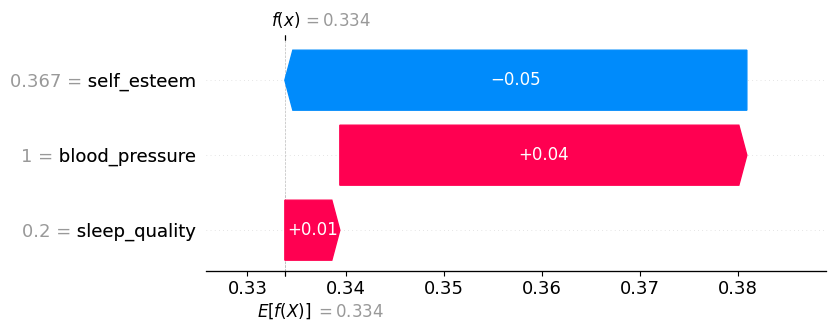


Explicação Local — CASO BORDA (INCERTEZA) (Índice Original 26)
Verdadeiro: 1
Predito: 1
Confiança: 0.35


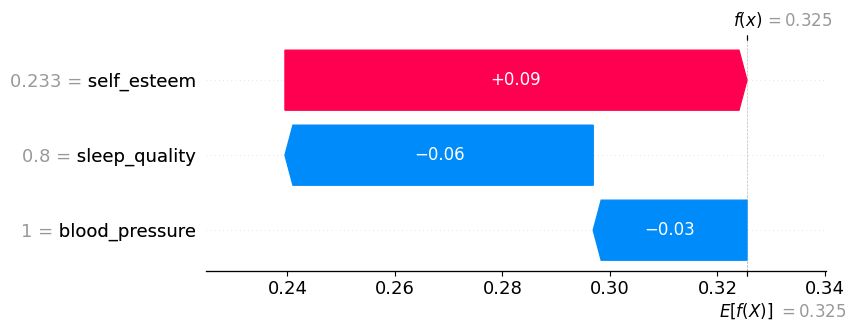

In [ ]:
explicar_instancia(idx_acerto, "ACERTO")
explicar_instancia(idx_erro, "ERRO")
explicar_instancia(idx_borda, "CASO BORDA (INCERTEZA)")

### LIME - MLP

In [ ]:
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd


instance_index_mlp = {
    "ACERTO": idx_acerto,
    "ERRO": idx_erro,
    "BORDA (INCERTEZA)": idx_borda
}


explainer_mlp_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_mlp_train.values,
    feature_names=X_mlp_train.columns.tolist(),
    class_names=[0, 1, 2],
    mode='classification',
    random_state=42
)

def explicar_instancia_lime(idx, nome):
    instance_to_explain_mlp = X_mlp_test.iloc[idx]
    true_label = y_test.iloc[idx]


    instance_df = instance_to_explain_mlp.to_frame().T
    mlp_prediction = mlp.predict(instance_df)[0]


    exp = explainer_mlp_lime.explain_instance(
        data_row=instance_to_explain_mlp.values,
        predict_fn=mlp.predict_proba,
        num_features=10
    )

    print(f"\nExplicação Local LIME — {nome} (Índice Original {idx})")
    print(f"Verdadeiro: {true_label}\nPredito: {mlp_prediction}\n")


    /exp.show_in_notebook(show_table=True, colors={'positive': 'green', 'negative': 'red'}, figsize=(600, 400))

    exp.show_in_notebook(show_table=True)



for nome, idx in instance_index_mlp.items():
    explicar_instancia_lime(idx, nome)

SyntaxError: expression expected after dictionary key and ':' (ipython-input-1827848364.py, line 41)

In [ ]:
fig = exp.as_pyplot_figure()
fig.set_facecolor("white")
fig.savefig("explicacao_lime.png", dpi=300, facecolor="white")
plt.show()


## EXPORTAÇÃO PARA POWER BI

In [ ]:
import pandas as pd
import numpy as np

# 1. DADOS BASE
# Resultados de teste com predições
df_resultados_teste = pd.DataFrame({
    'id_estudante': range(len(y_test)),
    'classe_real': y_test.values,
    'classe_predita_rf': rf.predict(X_rf_test),
    'classe_predita_mlp': mlp.predict(X_mlp_test),
    'confianca_rf': rf.predict_proba(X_rf_test).max(axis=1),
    'confianca_mlp': mlp.predict_proba(X_mlp_test).max(axis=1),
    'acertou_rf': (rf.predict(X_rf_test) == y_test.values).astype(int),
    'acertou_mlp': (mlp.predict(X_mlp_test) == y_test.values).astype(int)
})

# Adicionar features originais
for col in X_rf_test.columns:
    df_resultados_teste[col] = X_rf_test[col].values

df_resultados_teste.to_csv('power_bi_resultados_teste.csv', index=False)
print("✅ Arquivo 1: power_bi_resultados_teste.csv")


# 2. IMPORTÂNCIA DAS FEATURES (SHAP)
shap_arr = np.array(shap_values_rf)
shap_abs_mean = np.mean(np.abs(shap_arr), axis=0)
mean_shap_global = np.mean(shap_abs_mean, axis=1)

df_importancia_features = pd.DataFrame({
    'feature': X_rf_test.columns,
    'importancia_shap': mean_shap_global,
    'categoria': X_rf_test.columns.map(category_mapping)
})

# Calcular percentual
total_imp = df_importancia_features['importancia_shap'].sum()
df_importancia_features['percentual'] = (
    df_importancia_features['importancia_shap'] / total_imp * 100
)

df_importancia_features = df_importancia_features.sort_values(
    'importancia_shap', ascending=False
).reset_index(drop=True)

df_importancia_features['rank'] = range(1, len(df_importancia_features) + 1)

df_importancia_features.to_csv('power_bi_importancia_features.csv', index=False)
print("✅ Arquivo 2: power_bi_importancia_features.csv")


# 3. IMPORTÂNCIA POR CLASSE
dados_por_classe = []

for classe in range(shap_abs_mean.shape[1]):
    for idx, feature in enumerate(X_rf_test.columns):
        dados_por_classe.append({
            'feature': feature,
            'classe': classe,
            'classe_label': f'Estresse {"Baixo" if classe==0 else "Médio" if classe==1 else "Alto"}',
            'importancia_shap': shap_abs_mean[idx, classe],
            'categoria': category_mapping.get(feature, 'Outros')
        })

df_importancia_por_classe = pd.DataFrame(dados_por_classe)
df_importancia_por_classe.to_csv('power_bi_importancia_por_classe.csv', index=False)
print("✅ Arquivo 3: power_bi_importancia_por_classe.csv")


# 4. IMPORTÂNCIA POR CATEGORIA
df_importancia_categoria = df_importancia_features.groupby('categoria').agg({
    'importancia_shap': 'sum',
    'percentual': 'sum'
}).reset_index()

df_importancia_categoria = df_importancia_categoria.sort_values(
    'importancia_shap', ascending=False
)

df_importancia_categoria.to_csv('power_bi_importancia_categoria.csv', index=False)
print("✅ Arquivo 4: power_bi_importancia_categoria.csv")


# 5. VALORES SHAP INDIVIDUAIS (para casos específicos)
casos_interesse = {
    'acerto': idx_acerto,
    'erro': idx_erro,
    'borda': idx_borda
}

dados_shap_individual = []

for tipo_caso, idx in casos_interesse.items():
    # Pegar a classe predita
    pred = rf.predict(X_rf_test.iloc[[idx]])[0]

    # Valores SHAP para aquele caso
    idx_safe = idx if idx < shap_values[pred].shape[0] else idx % shap_values[pred].shape[0]
    shap_vector = shap_values[pred][idx_safe]

    # IMPORTANTE: shap_vector tem o mesmo tamanho que X_rf_test.columns
    # Verificar se é 1D ou 2D
    if len(shap_vector.shape) > 1:
        shap_vector = shap_vector.flatten()

    # Iterar APENAS sobre as features que realmente existem no X_rf_test
    num_features = len(X_rf_test.columns)

    # Garantir que shap_vector tem o tamanho correto
    if len(shap_vector) != num_features:
        num_features = min(len(shap_vector), num_features)

    for feat_idx in range(num_features):
        feature = X_rf_test.columns[feat_idx]

        dados_shap_individual.append({
            'id_estudante': idx,
            'tipo_caso': tipo_caso,
            'feature': feature,
            'valor_feature': X_rf_test.iloc[idx][feature],
            'shap_value': float(shap_vector[feat_idx]),  # Converter para float
            'base_value': float(explainer_rf.expected_value[pred]),
            'classe_real': int(y_test.iloc[idx]),
            'classe_predita': int(pred),
            'categoria': category_mapping.get(feature, 'Outros')
        })

df_shap_individual = pd.DataFrame(dados_shap_individual)

# Verificação de sanidade
print(f"\n✅ Arquivo 5: power_bi_shap_individual.csv")
print(f"   Total de linhas: {len(df_shap_individual)}")
print(f"   Casos: {df_shap_individual['tipo_caso'].unique()}")
print(f"   Features por caso: {len(df_shap_individual[df_shap_individual['tipo_caso']=='acerto'])}")

df_shap_individual.to_csv('power_bi_shap_individual.csv', index=False)

# 6. MATRIZ DE CONFUSÃO
from sklearn.metrics import confusion_matrix

cm_rf = confusion_matrix(y_test, rf.predict(X_rf_test))
cm_mlp = confusion_matrix(y_test, mlp.predict(X_mlp_test))

dados_cm = []
for i in range(3):  # 3 classes
    for j in range(3):
        dados_cm.append({
            'classe_real': i,
            'classe_predita': j,
            'quantidade_rf': int(cm_rf[i, j]),
            'quantidade_mlp': int(cm_mlp[i, j]),
            'real_label': f'Real: {"Baixo" if i==0 else "Médio" if i==1 else "Alto"}',
            'pred_label': f'Pred: {"Baixo" if j==0 else "Médio" if j==1 else "Alto"}',
            'acertou': 'Sim' if i == j else 'Não'
        })

df_matriz_confusao = pd.DataFrame(dados_cm)
df_matriz_confusao.to_csv('power_bi_matriz_confusao.csv', index=False)
print("✅ Arquivo 6: power_bi_matriz_confusao.csv")


# 7. MÉTRICAS DO MODELO
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

metricas = []

for modelo_nome, y_pred in [('Random Forest', rf.predict(X_rf_test)),
                             ('MLP', mlp.predict(X_mlp_test))]:
    metricas.append({
        'modelo': modelo_nome,
        'metrica': 'Acurácia',
        'valor': accuracy_score(y_test, y_pred) * 100
    })
    metricas.append({
        'modelo': modelo_nome,
        'metrica': 'F1-Score',
        'valor': f1_score(y_test, y_pred, average='macro')
    })
    metricas.append({
        'modelo': modelo_nome,
        'metrica': 'Precisão',
        'valor': precision_score(y_test, y_pred, average='macro')
    })
    metricas.append({
        'modelo': modelo_nome,
        'metrica': 'Recall',
        'valor': recall_score(y_test, y_pred, average='macro')
    })

df_metricas = pd.DataFrame(metricas)
df_metricas.to_csv('power_bi_metricas.csv', index=False)
print("✅ Arquivo 7: power_bi_metricas.csv")


# 8. TABELA DIMENSÃO - MAPEAMENTOS

# Dimensão de Classes
df_dim_classes = pd.DataFrame({
    'classe_id': [0, 1, 2],
    'classe_nome': ['Baixo', 'Médio', 'Alto'],
    'classe_cor': ['#4CAF50', '#FFC107', '#F44336']
})
df_dim_classes.to_csv('power_bi_dim_classes.csv', index=False)

# Dimensão de Categorias
df_dim_categorias = pd.DataFrame({
    'categoria': ['Psicológicos', 'Fisiológicos', 'Ambientais', 'Acadêmicos', 'Sociais'],
    'cor': ['#9C27B0', '#FF9800', '#795548', '#2196F3', '#4CAF50'],
    'ordem': [1, 2, 3, 4, 5]
})
df_dim_categorias.to_csv('power_bi_dim_categorias.csv', index=False)

# Dimensão de Features
df_dim_features = pd.DataFrame({
    'feature': list(category_mapping.keys()),
    'categoria': list(category_mapping.values()),
    'descricao': [
        'Nível de ansiedade', 'Autoestima', 'Histórico de saúde mental', 'Depressão',
        'Dor de cabeça', 'Pressão arterial', 'Qualidade do sono', 'Problemas respiratórios',
        'Nível de ruído', 'Condições de moradia', 'Segurança', 'Necessidades básicas',
        'Desempenho acadêmico', 'Carga de estudos', 'Relação professor-aluno', 'Preocupações com carreira',
        'Apoio social', 'Pressão dos pares', 'Atividades extracurriculares', 'Bullying'
    ]
})
df_dim_features.to_csv('power_bi_dim_features.csv', index=False)